In [1]:
from loadptn import train_data_loader, z_max, z_min, y_max, y_min, x_max, x_min, atom_pos, atom_type
import os
import numpy as np
def get_data(fdir):
    files = os.listdir('./')

    #print(load_feature_dimensions(files, fdir))
    # Initialize the feature set
    feature_set = None
    if os.path.isfile(fdir+'.npy'):
        feature_set = np.load(fdir+'.npy')
    else:
        feature_set = np.zeros(shape=(len(files), z_max-z_min, y_max-y_min, x_max-x_min, 1 + len(atom_type) + len(atom_pos)))
        train_data_loader(files, feature_set, fdir=fdir)
        np.save(fdir, feature_set)

    return feature_set

In [2]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from loadptn import x_min, y_min, z_min, x_max, y_max, z_max, atom_pos, atom_type
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
from sklearn.metrics import classification_report, confusion_matrix
print((z_max-z_min, y_max-y_min, x_max-x_min, 1 + len(atom_type) + len(atom_pos)))
#Make it have size 32x32x32x48

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(z_max-z_min, y_max-y_min, x_max-x_min, 1 + len(atom_type) + len(atom_pos))),
        layers.GlobalMaxPooling3D(),
        layers.Dense(20),
        layers.ReLU(),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator 32 32 48
latent_dim = 1 + len(atom_type) + len(atom_pos)
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
#         layers.Dense(8* latent_dim),
#         layers.LeakyReLU(alpha=0.2),
#         layers.BatchNormalization(momentum=0.8),
#         layers.Dense(8*8* latent_dim),
#         layers.LeakyReLU(alpha=0.2),
#         layers.BatchNormalization(momentum=0.8),
#         layers.Dense(12*8*8* latent_dim),
#         layers.LeakyReLU(alpha=0.2),
#         layers.BatchNormalization(momentum=0.8),
#         layers.Dense(4*12*8*8* latent_dim),
#         layers.LeakyReLU(alpha=0.2),
#         layers.BatchNormalization(momentum=0.8),
#         layers.Dense(4*4*12*8*8* latent_dim),
#         layers.LeakyReLU(alpha=0.2),
#         layers.BatchNormalization(momentum=0.8),
        layers.Dense(4*4*4*12*8*8* latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Reshape((48, 32, 32, latent_dim)),
    ],
    name="generator",
)


# 1867776
# 48,32,32,38



class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.01 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions_d = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions_d)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}
    def call(inputs):
        random_latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return self.generator(random_latent_vectors)



(48, 32, 32, 38)


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling3d (Global (None, 38)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                780       
_________________________________________________________________
re_lu (ReLU)                 (None, 20)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 881
Trainable params: 841
Non-trainable params: 40
_________________________________________________________________
None
Model: "generator"
_________________________________________________________________
Layer (type)                 O

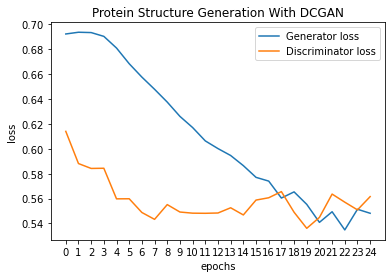

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from loadptn import x_min, y_min, z_min, x_max, y_max, z_max, atom_pos, atom_type

def main(epochs, batch_size, file_dir, train=True):
    # Prepare the dataset. We use both the training & test MNIST digits.
    x = get_data(file_dir)
    # Change [37,26,32,38] to [40,27,32,38]
    # x = np.pad(not_padded, ((0, 0),(1, 2), (1, 0), (0, 0), (0, 0)), 'mean')
    print(discriminator.summary())
    print(generator.summary())
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, batch_size=batch_size)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )
    # To limit the execution time, we only train on 100 batches. You can train on
    # the entire dataset. You will need about 20 epochs to get nice results.
    if train:
        history = gan.fit(x, batch_size=batch_size, epochs=epochs)
        gan.discriminator.save('gan_discriminator')
        gan.generator.save('gan_generator')

        g_loss, d_loss = history.history['g_loss'], history.history['d_loss']
        plt.plot(g_loss)
        plt.plot(d_loss)
        plt.xticks(np.arange(0, epochs, step=1))  # Set label locations.
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Protein Structure Generation With DCGAN')
        plt.legend(['Generator loss', 'Discriminator loss'], loc='upper right')
        plt.show()
    else:
        gan.discriminator = keras.models.load_model('gan_disciminator')
        gan.generator = keras.models.load_model('gan_generator')
def get_accuracies(pred, labels, threshold=.5):
    pred_output = pred.copy()
    labels_output = labels.copy()

    pred_output[pred_output >= threshold] = 1
    pred_output[pred_output < threshold] = 0

    labels_output[labels_output >= threshold] = 1
    labels_output[labels_output < threshold] = 0

    accuracies = []
    for i in range(pred_output.shape[0]):
        accuracies.append(accuracy_score(labels_output[i], pred_output[i]))
    return accuracies
    #print(classification_report(labels_output,pred_output))


# Plot Accuracy and Loss
def plot_training_loss(history):
	# Plot training & validation accuracy values
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Model accuracy')
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

	# Plot training & validation loss values
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()


if __name__ == '__main__':
    epochs = 25
    batch_size = 32
    main(epochs, batch_size, 'ptn11H_1000')
